# Определение температуры стали

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

In [2]:
try:
    data_arc = pd.read_csv('final_steel/data_arc.csv')
    data_bulk = pd.read_csv('final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('final_steel/data_gas.csv')
    data_temp = pd.read_csv('final_steel/data_temp.csv')
    data_wire = pd.read_csv('final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

## Исследовательский анализ.

In [3]:
def analysis(df):    
    display(df.head())
    print('')
    print('Сводная информация по таблице')
    print('')
    display(df.info())
    print('')
    print('Количество пропущенных значений')
    report = df.isna().sum().to_frame()
    report = report.rename(columns = {0: 'missing_values'})
    report['% of total'] = (report['missing_values'] * 100 / df.shape[0]).round(2)
    display(report.sort_values(by = 'missing_values', ascending = False))
    print('')
    print('Распределение значений')
    display(df.describe())    

### Данные об электродах.

In [4]:
analysis(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



Сводная информация по таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None


Количество пропущенных значений


,missing_values,% of total
key,0,0.0
Начало нагрева дугой,0,0.0
Конец нагрева дугой,0,0.0
Активная мощность,0,0.0
Реактивная мощность,0,0.0



Распределение значений


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


На данном этапе выбивается только наличие отрицательных значений реактивной мощности. Проверим как много таких значений:

In [5]:
data_arc[data_arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [6]:
data_arc[data_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Это похоже на ошибку измерительных приборов. Предлагаю вычислить данное значение пропорцией с помощью соседних измерений.

In [7]:
 data_arc = data_arc.replace(
    data_arc['Реактивная мощность'][9780],
    data_arc['Реактивная мощность'][9781] * data_arc['Активная мощность'][9780] / data_arc['Активная мощность'][9781]
)

In [8]:
data_arc[data_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,0.329225
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Посмотрим, различается ли число включений электродов между партиями.

In [9]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

Возможно, данное различие можно будет использовать как один из признаков при обучении модели. Также, теоретически, из данной таблицы можно будет "достать" для каждой партии суммарное время нагрева, суммарные активную и реактивную мощности. Судя по информации из общедоступных источников (например, https://khomovelectro.ru/articles/aktivnaya-reaktivnaya-i-polnaya-kazhushchayasya-moshchnosti.html) можно дополнительно посчитать ещё и полную мощность.

### Данные о подаче сыпучих материалов (объём).

In [10]:
analysis(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Сводная информация по таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None


Количество пропущенных значений


,missing_values,% of total
Bulk 8,3128,99.97
Bulk 13,3111,99.42
Bulk 9,3110,99.39
Bulk 2,3107,99.30
Bulk 7,3104,99.20
Bulk 5,3052,97.54
Bulk 10,2953,94.38
Bulk 11,2952,94.34
Bulk 1,2877,91.95
Bulk 6,2553,81.59



Распределение значений


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Из тех. задания можно понять, что в столбцах Bulk 1-15 указан объём легирующих добавок, добавляемых на определённой стадии. Пропуски означают, что добавка не использовалась при производстве партии. Являются эти данные разными объёмами одного компонента, загруженного в определённый момент времени, или все они различаются по составу, установить не удалось. Возможно, для обучения можно попробовать использовать как все по тодельности, так и сумму компонентов.

### Данные о подаче сыпучих материалов (время).

In [11]:
analysis(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



Сводная информация по таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None


Количество пропущенных значений


,missing_values,% of total
Bulk 8,3128,99.97
Bulk 13,3111,99.42
Bulk 9,3110,99.39
Bulk 2,3107,99.30
Bulk 7,3104,99.20
Bulk 5,3052,97.54
Bulk 10,2953,94.38
Bulk 11,2952,94.34
Bulk 1,2877,91.95
Bulk 6,2553,81.59



Распределение значений


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


В таблице указано время ввода легирующих добавок в расплав. После обсуждения, данную информацию решено не использовать.

### Данные о продувке сплава газом.

In [12]:
analysis(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Сводная информация по таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


Количество пропущенных значений


,missing_values,% of total
key,0,0.0
Газ 1,0,0.0



Распределение значений


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


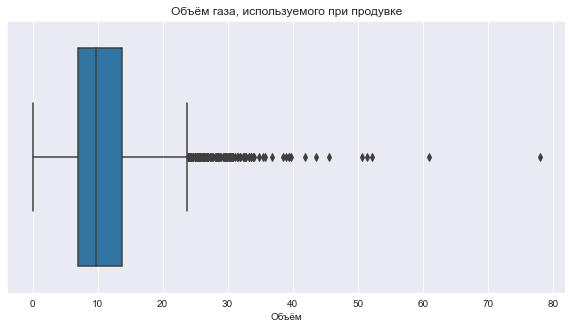

In [13]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')

sns.boxplot(x=data_gas['Газ 1'])

plt.xlabel('Объём')
plt.title('Объём газа, используемого при продувке')

plt.show()

Исходя из тех. задания продув сплава инертным газом может производиться несколько раз. Однако, в отличие от таблицы с данными по сыпучим компонентам, здесь дан суммарный объём. Выбивающиеся значения (> 40) скорее всего являются особенностями марок стали, производящихся редко. Оставим их для обучения.

### Результаты измерения температуры.

In [14]:
analysis(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



Сводная информация по таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None


Количество пропущенных значений


,missing_values,% of total
Температура,2901,18.24
key,0,0.00
Время замера,0,0.00



Распределение значений


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


При обсуждении задачи решено, что  в качестве целевого признака нужно использовать последний замер температуры, а первый как один из признаков. Присутствуют пропуски в ~18% данных.

In [15]:
data_temp[data_temp['Температура'].isna()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


На примере партии 3241 проверим, какие именно значения пропущены.

In [16]:
data_temp[data_temp['key'] == 3241]

,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


Необходимо выяснить, в чём может быть причина отсутствия замеров.

Посмотрим на распределение температур в таблице.

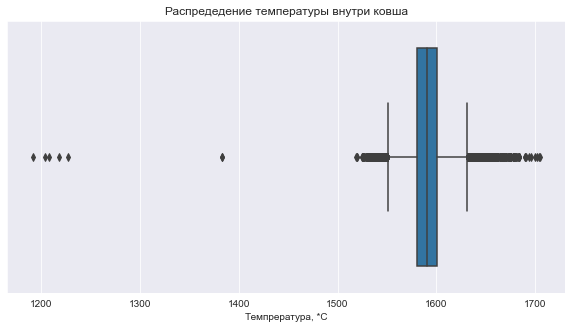

In [17]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')

sns.boxplot(x=data_temp['Температура'])

plt.xlabel('Темпрература, *С')
plt.title('Распредедение температуры внутри ковша')

plt.show()

Имеется несколько значений сильно меньше среднего.

In [18]:
data_temp[data_temp['Температура'] < 1500]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


Исходя из доступной информации установлено, что температура плавления стали ~1500 °С. Данные температуры являются ошибкой. Т.к. для обучения нужны только первый и последний замер, на этапе предобработки удалим все партии, в которых ошибочные замеры являются таковыми.

### Данные о проволочных материалах (объём).

In [19]:
analysis(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Сводная информация по таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


Количество пропущенных значений


,missing_values,% of total
Wire 5,3080,99.97
Wire 7,3070,99.64
Wire 4,3067,99.55
Wire 8,3062,99.38
Wire 9,3052,99.06
Wire 3,3018,97.96
Wire 6,3008,97.63
Wire 2,2002,64.98
Wire 1,26,0.84
key,0,0.00



Распределение значений


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Аналогично с данными по сыпучим материалам, пропуски означают, что проволока не загружалась (подобные значения заменим на 0).

### Данные о проволочных материалах (время).

In [20]:
analysis(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Сводная информация по таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None


Количество пропущенных значений


,missing_values,% of total
Wire 5,3080,99.97
Wire 7,3070,99.64
Wire 4,3067,99.55
Wire 8,3062,99.38
Wire 9,3052,99.06
Wire 3,3018,97.96
Wire 6,3008,97.63
Wire 2,2002,64.98
Wire 1,26,0.84
key,0,0.00



Распределение значений


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Как и в случае со временем добавления сыпучих веществ, время добавления пролочных материалов использовано не будет.

## Предобработка данных.

### Данные об электродах.

Приведём время включения и выключения электродов к формату даты.

In [21]:
def datetime(df):   
    date_columns = df.select_dtypes(include='object').columns.to_list()    
    for column in date_columns:
        df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S')
        
datetime(data_arc)

Рассчитаем в секундах время нагрева каждого цикла:

In [22]:
data_arc['heating_time'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['heating_time'] = pd.TimedeltaIndex(data_arc['heating_time']).total_seconds()

Рассчитаем для каждой партии суммарные активную и реактивную мощности, а также суммарное время нагрева и число включений электродов:

In [23]:
arc_features = (
    data_arc
    .groupby('key')
    .agg({'Активная мощность': 'sum', 'Реактивная мощность': 'sum', 'heating_time': ('sum', 'count')})
    .reset_index()
)

arc_features.columns = ['key', 'active_power', 'reactive_power', 'heating_time', 'heating_ammount']
arc_features

,key,active_power,reactive_power,heating_time,heating_ammount
0,1,4.878147,3.183241,1098.0,5
1,2,3.052598,1.998112,811.0,4
2,3,2.525882,1.599076,655.0,5
3,4,3.209250,2.060298,741.0,4
4,5,3.347173,2.252643,869.0,4
...,...,...,...,...,...
3209,3237,3.932467,2.828459,909.0,5
3210,3238,2.106529,1.681182,546.0,3
3211,3239,4.666754,3.111617,1216.0,8
3212,3240,2.984083,2.483267,839.0,5


Добавим ещё один признак - полную мощность:

In [24]:
arc_features['apparent_power'] = (arc_features['active_power']**2 + arc_features['reactive_power']**2)**0.5

### Данные о подаче сыпучих материалов (объём).

Заменим пропуски нулевыми значения и рассчитаем для каждой партии суммарное количество добавленных сыпучих материалов.

In [25]:
data_bulk = data_bulk.fillna(0)

data_bulk['bulk_sum'] = (
    data_bulk['Bulk 1'] + data_bulk['Bulk 2'] + data_bulk['Bulk 3'] + data_bulk['Bulk 4'] +
    data_bulk['Bulk 5'] + data_bulk['Bulk 6'] + data_bulk['Bulk 7'] + data_bulk['Bulk 8'] +
    data_bulk['Bulk 9'] + data_bulk['Bulk 10'] + data_bulk['Bulk 11'] + data_bulk['Bulk 12'] + 
    data_bulk['Bulk 13'] + data_bulk['Bulk 14'] + data_bulk['Bulk 15']
)

### Данные о подаче проволочных материалов (объём).

По аналогии с сыпучими материалами заменим пропуски нулями и рассчитаем суммарное количество.

In [26]:
data_wire = data_wire.fillna(0)

data_wire['wire_sum'] = (
    data_wire['Wire 1'] + data_wire['Wire 2'] + data_wire['Wire 3'] + data_wire['Wire 4'] + data_wire['Wire 5'] + 
    data_wire['Wire 6'] + data_wire['Wire 7'] + data_wire['Wire 8'] + data_wire['Wire 9']
)

### Данные о продувке сплава газом.

Переименуем название столбца.

In [27]:
data_gas = data_gas.rename(columns={'Газ 1': 'gas_volume'})

### Результаты измерения температуры.

Рассмотрим значения температуры ниже 1500 °С.

In [28]:
data_temp[data_temp['Температура'] < 1500]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


Посмотрим, какими по счёту для своей партии они являются.

In [29]:
data_temp[data_temp['key'].isin([867, 1214, 1619, 1818, 2052, 2561])]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0
5978,1214,2019-06-16 05:32:00,1208.0
5979,1214,2019-06-16 05:49:01,1608.0
5980,1214,2019-06-16 05:51:28,1608.0
5981,1214,2019-06-16 05:51:38,1608.0


Все замеры, кроме партии №1818, являются первыми. Удалим данные партии из таблицы.

In [30]:
data_temp = (
    data_temp
    .set_index('key')
    .drop([867, 1214, 1619, 2052, 2561])
    .reset_index()
)

Убедимся, что для каждой партии есть несколько замеров температуры.

In [31]:
data_temp['key'].value_counts()

44      16
46      16
1513    16
1689    15
2108    15
        ..
1424     2
568      2
977      2
279      1
195      1
Name: key, Length: 3211, dtype: int64

Такие замеры стоит исключить.

In [32]:
data_temp[(data_temp['key'] == 195) | (data_temp['key'] == 279)]

,key,Время замера,Температура
1100,195,2019-05-10 14:10:23,1583.0
1554,279,2019-05-13 23:07:28,1603.0


In [33]:
data_temp = data_temp.drop(labels=[1100, 1554])

Выделим для каждой партии первый и последний замеры температуры. Для этого заменим пропуски на 0. А после выделения температур, удалим все партии, в которых нулевые значения окажутся первым или последним замерами. 

In [34]:
temp_features = (
    data_temp
    .fillna(0)
    .groupby('key')
    .agg(['first', 'last'])
    .reset_index()
)

temp_features.columns = ['key', 'first_time', 'last_time', 'first_temp', 'last_temp']

temp_features = (
    temp_features[(temp_features['first_temp'] != 0) & (temp_features['last_temp'] != 0)]
    .drop(['first_time', 'last_time'], axis=1)
)

### Объединение признаков в одну таблицу.

In [35]:
full_table = (
    temp_features
    .merge(arc_features, how='left', on='key')
    .merge(data_bulk, how='left', on='key')
    .merge(data_wire, how='left', on='key')
    .merge(data_gas, how='left', on='key')
    .set_index('key')
)

Прверим, имеются ли в таблице данные для всех партий.

In [36]:
analysis(full_table)

,first_temp,last_temp,active_power,reactive_power,heating_time,heating_ammount,apparent_power,Bulk 1,Bulk 2,Bulk 3,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum,gas_volume
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,4.878147,3.183241,1098.0,5,5.824889,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986
2,1581.0,1602.0,3.052598,1.998112,811.0,4,3.648398,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561
3,1596.0,1599.0,2.525882,1.599076,655.0,5,2.989502,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793
4,1601.0,1625.0,3.209250,2.060298,741.0,4,3.813674,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,18.841219
5,1576.0,1602.0,3.347173,2.252643,869.0,4,4.034596,0.0,0.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,5.413692



Сводная информация по таблице

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   first_temp       2471 non-null   float64
 1   last_temp        2471 non-null   float64
 2   active_power     2471 non-null   float64
 3   reactive_power   2471 non-null   float64
 4   heating_time     2471 non-null   float64
 5   heating_ammount  2471 non-null   int64  
 6   apparent_power   2471 non-null   float64
 7   Bulk 1           2403 non-null   float64
 8   Bulk 2           2403 non-null   float64
 9   Bulk 3           2403 non-null   float64
 10  Bulk 4           2403 non-null   float64
 11  Bulk 5           2403 non-null   float64
 12  Bulk 6           2403 non-null   float64
 13  Bulk 7           2403 non-null   float64
 14  Bulk 8           2403 non-null   float64
 15  Bulk 9           2403 non-null   float64
 16  Bulk 10          2403 non-nu

None


Количество пропущенных значений


,missing_values,% of total
Wire 3,103,4.17
wire_sum,103,4.17
Wire 9,103,4.17
Wire 8,103,4.17
Wire 7,103,4.17
Wire 6,103,4.17
Wire 2,103,4.17
Wire 1,103,4.17
Wire 4,103,4.17
Wire 5,103,4.17



Распределение значений


,first_temp,last_temp,active_power,reactive_power,heating_time,heating_ammount,apparent_power,Bulk 1,Bulk 2,Bulk 3,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum,gas_volume
count,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2403.000000,2403.000000,2403.000000,...,2368.000000,2368.000000,2368.000000,2368.0,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2469.000000
mean,1589.012950,1595.339943,3.129056,2.331896,800.304330,4.626467,3.908083,3.322097,1.378693,46.005410,...,17.852648,3.181638,0.301501,0.0,0.962699,0.006256,0.306184,0.415018,125.259284,11.145730
std,25.004369,16.035215,1.425844,1.078559,340.783792,1.609465,1.775364,12.233788,18.787490,74.537148,...,33.962436,27.714773,4.718549,0.0,8.622284,0.204005,4.366466,4.335303,64.055006,6.327159
min,1519.000000,1541.000000,0.186226,0.158247,57.000000,1.000000,0.257637,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.918800,0.008399
25%,1572.000000,1587.000000,2.150641,1.609379,573.000000,4.000000,2.692047,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,88.251540,7.105241
50%,1588.000000,1593.000000,3.016664,2.230260,773.000000,4.000000,3.754464,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,116.106121,9.926730
75%,1605.000000,1599.000000,3.908544,2.907400,987.000000,6.000000,4.863299,0.000000,0.000000,76.000000,...,23.153520,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,151.630436,13.872686
max,1679.000000,1700.000000,17.496497,12.587990,4189.000000,16.000000,21.554231,185.000000,325.000000,454.000000,...,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,90.053604,568.777664,77.995040


Образовались пропуски в столбцах с объёмами сыпучих компонентов, проволоки и газа. Проверим, имеются ли партии, в которых отсутствуют все типы добавок.

In [37]:
full_table[full_table['bulk_sum'].isna() & full_table['wire_sum'].isna() & full_table['gas_volume'].isna()]

,first_temp,last_temp,active_power,reactive_power,heating_time,heating_ammount,apparent_power,Bulk 1,Bulk 2,Bulk 3,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum,gas_volume
key,,,,,,,,,,,,,,,,,,,,,


Т.к. таких строк нет, можно предположить, что один из типов добавок не используется при производстве определённых марок стали. Заменим пропуски на 0.

In [38]:
full_table = full_table.fillna(0)

In [39]:
full_table.head()

,first_temp,last_temp,active_power,reactive_power,heating_time,heating_ammount,apparent_power,Bulk 1,Bulk 2,Bulk 3,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum,gas_volume
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,4.878147,3.183241,1098.0,5,5.824889,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986
2,1581.0,1602.0,3.052598,1.998112,811.0,4,3.648398,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561
3,1596.0,1599.0,2.525882,1.599076,655.0,5,2.989502,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793
4,1601.0,1625.0,3.209250,2.060298,741.0,4,3.813674,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,18.841219
5,1576.0,1602.0,3.347173,2.252643,869.0,4,4.034596,0.0,0.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,5.413692


### Определение влияния признаков на целевой признак.

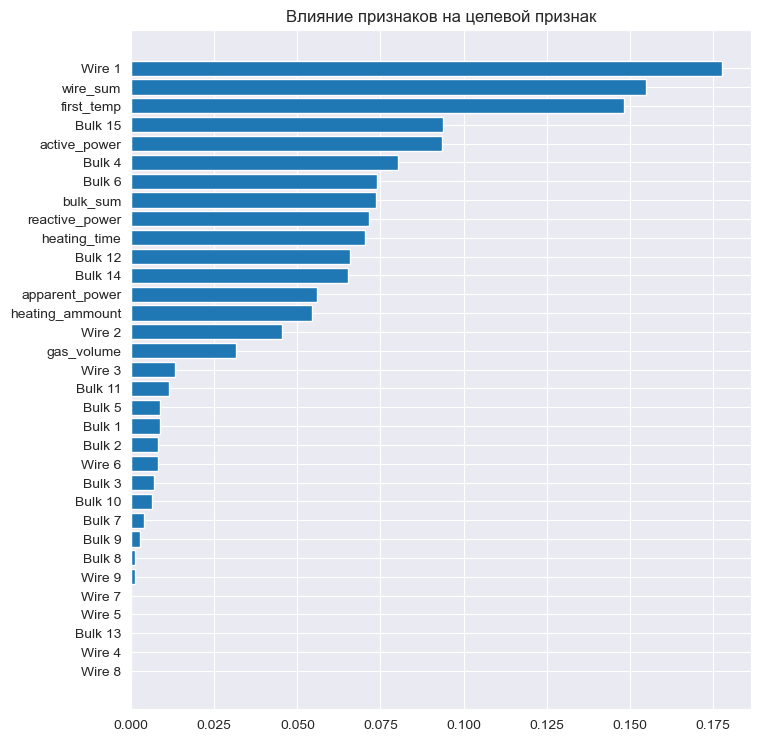

In [40]:
X = full_table.drop(['last_temp'], axis=1)
y = full_table['last_temp']
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=12345)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Влияние признаков на целевой признак')

plt.figure(dpi=100, figsize=(8, 9))
plot_mi_scores(mi_scores)

Судя по графику, признаки с наиболее сильным влиянием на финальную температуру - первая температура, объём первой проволоки, активная мощность, суммарный объём подаваемой проволоки, объём сыпучего компонента №15. Наименьшее влияние имеет большинство загружаемых сыпучих материалов и проволоки.

### Разделение на обучающую и тестовую выборки. Масштабирование признаков.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Обучение моделей.

In [42]:
def model_learning_results(model, param_grid, X_train, X_test, y_train, y_test):
    
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
    )    
    grid_search.fit(X_train, y_train)    
    best_params = grid_search.best_params_
    
    train_pred = grid_search.predict(X_train_scaled)
    test_pred = grid_search.predict(X_test_scaled)
    
    mae_train = mean_absolute_error(y_train, train_pred)
    mae_test = mean_absolute_error(y_test, test_pred)
    
    result_list = ({
        'model': model,
        'best_params': best_params,
        'mae_train': mae_train,
        'mae_test': mae_test
    })
    return result_list

### DummyRegressor.

Обучим для начала модель, предсказывающую медианные значения.

In [43]:
dummy = DummyRegressor(strategy='median')

dummy.fit(X_train_scaled, y_train)
train_pred = dummy.predict(X_train_scaled)
test_pred = dummy.predict(X_test_scaled)

In [44]:
mae_train = mean_absolute_error(y_train, train_pred)
mae_train

9.832164058283864

In [45]:
mae_test = mean_absolute_error(y_test, test_pred)
mae_test

10.131067961165048

До целевого показателя метрики данная модель не дотягивается.

### Линейная регрессия.

In [46]:
%%time

lin_reg = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

lin_reg_results = model_learning_results(lin_reg, param_grid, X_train_scaled, X_test_scaled, y_train, y_test)

Wall time: 5.12 s


### Случайный лес.

In [47]:
%%time

random_forest = RandomForestRegressor()

param_grid = {
    'n_estimators': [10, 25, 50, 100],
    'max_depth': [1, 4, 7, 10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'random_state': [12345]
}

random_forest_results = model_learning_results(random_forest, param_grid, X_train_scaled, X_test_scaled, y_train, y_test)

Wall time: 1min 3s


### Градиентный спуск.

In [48]:
%%time

sgd_reg = SGDRegressor()

param_grid = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
    'max_iter': [1000],
    'early_stopping': [True],
    'random_state': [12345]
}

sgd_reg_results = model_learning_results(sgd_reg, param_grid, X_train_scaled, X_test_scaled, y_train, y_test)

Wall time: 1min 26s


### Градиентный бустинг.

#### GradientBoostingRegressor.

In [49]:
%%time

gbr = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [10, 25, 50, 100],
    'max_depth': [1, 4, 7, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'learning_rate': [1e-3, 1e-2, 1e-1, 1],
    'random_state': [12345]
}

gbr_results = model_learning_results(gbr, param_grid, X_train_scaled, X_test_scaled, y_train, y_test)

Wall time: 2min 32s


#### HistGradientBoostingRegressor

In [50]:
%%time

hist_gbr = HistGradientBoostingRegressor()

param_grid = {
    'max_depth': [1, 4, 7, 10],
    'min_samples_leaf': [5, 10],
    'learning_rate': [1e-3, 1e-2, 1e-1, 1],
    'max_iter': [1000],
    'early_stopping': [True],
    'random_state': [12345]
}

hist_gbr_results = model_learning_results(hist_gbr, param_grid, X_train_scaled, X_test_scaled, y_train, y_test)

Wall time: 1min 32s


#### LGBMRegressor

In [51]:
%%time

lightgbm = LGBMRegressor()

param_grid = {
    'max_depth': [1, 4, 7, 10],
    'learning_rate': [1e-3, 1e-2, 1e-1, 1],
    'n_estimators': [100, 150, 200, 250],
    'random_state': [12345]
}

lightgbm_results = model_learning_results(lightgbm, param_grid, X_train_scaled, X_test_scaled, y_train, y_test)

Wall time: 22.9 s


### Результаты обучения моделей.

In [52]:
final_results = pd.DataFrame(columns=['model', 'mae_train', 'mae_test', 'best_params'])

final_results = (
    final_results
    .append(lin_reg_results, ignore_index=True)
    .append(random_forest_results, ignore_index=True)
    .append(sgd_reg_results, ignore_index=True)
    .append(gbr_results, ignore_index=True)
    .append(hist_gbr_results, ignore_index=True)
    .append(lightgbm_results, ignore_index=True)
)

final_results.sort_values(by='mae_test', ascending=True)

,model,mae_train,mae_test,best_params
3,GradientBoostingRegressor(),4.163850,5.880371,"{'learning_rate': 0.1, 'max_depth': 4, 'min_sa..."
4,HistGradientBoostingRegressor(),3.941708,6.029999,"{'early_stopping': True, 'learning_rate': 0.1,..."
1,RandomForestRegressor(),4.023094,6.049468,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_..."
5,LGBMRegressor(),4.265654,6.099038,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
0,LinearRegression(),7.225821,7.438644,"{'fit_intercept': True, 'normalize': False}"
2,SGDRegressor(),7.421947,7.579637,"{'alpha': 0.001, 'early_stopping': True, 'lear..."


На примере лучшей модели рассмотрим влияние признаков на целевой признак.

In [53]:
params = gbr_results['best_params']

gbr = GradientBoostingRegressor(**params)

gbr.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=4, min_samples_split=3, random_state=12345)

In [54]:
feature_importance = (
    pd.DataFrame(gbr.feature_importances_, index=X_train.columns, columns=['features'])
    .sort_values(by='features', ascending=False)
)

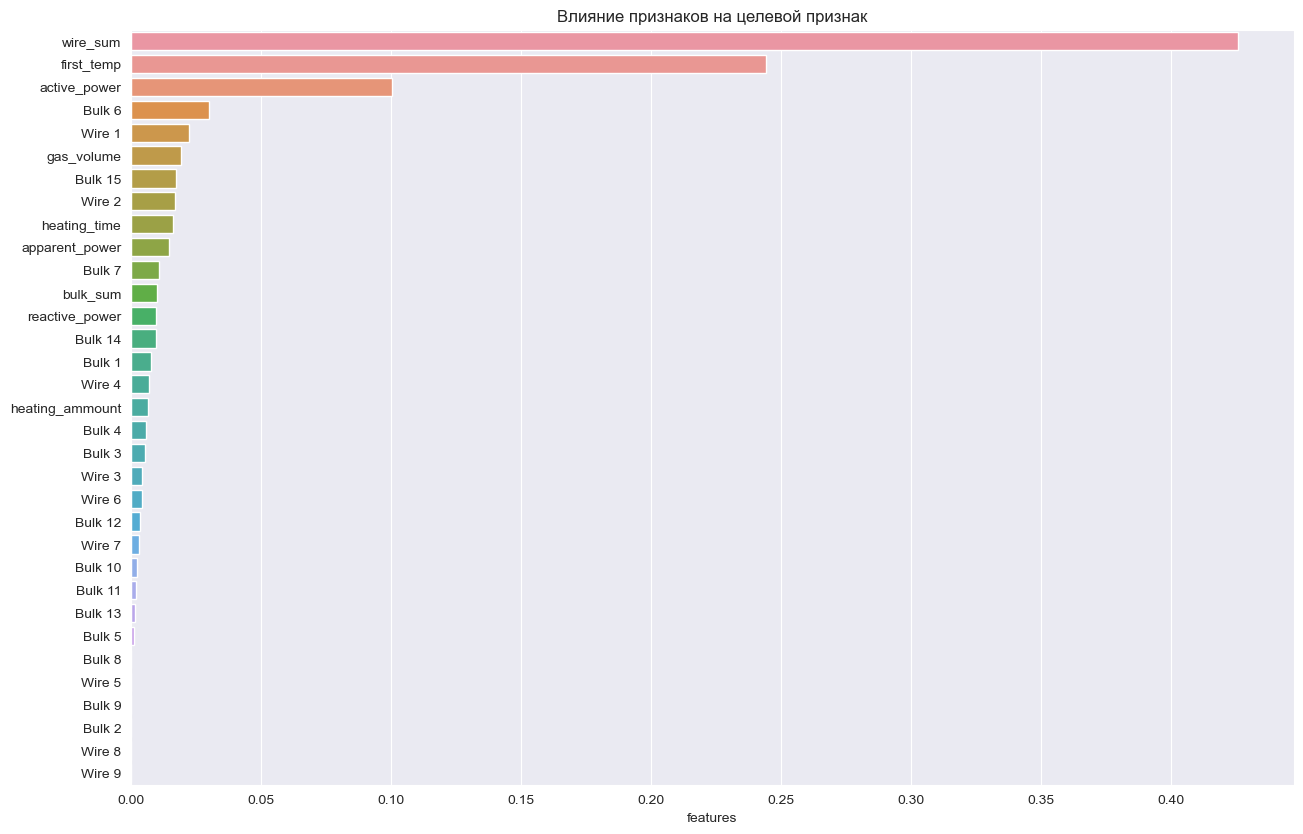

In [55]:
plt.figure(dpi=100, figsize=(15, 10))
sns.set_style('darkgrid')

sns.barplot(x='features', y=feature_importance.index, data=feature_importance)

plt.title('Влияние признаков на целевой признак')

plt.show()

В случае с градиентным бустингом наибольшее влияние оказывают сумммарный объём проволоки, первая температура и активная мощность. В целом, отличий от изначальной оценки влияния нет.

## Вывод.

Целью данной работы было построение регрессионной модели для определения температуры расплава стали после этапа обработки. От заказчика были получены следующие данные:
 - показатели активной и реактивной мощности, а также временные интервалы включения электродов для каждой партии;
 - объёмы подаваемых в расплав сыпучих и проволочных материалов с указанием времени подачи;
 - объёмы подаваемого инертного газа;
 - времена замеров и значения температур для каждой партии.

Целевым признаком был выбран последний замер температуры для каждой партии. Метрика оценки - МАЕ. В качестве признаков использовались следующие значения:
 - суммарное время включения электродов, количество данных включений;
 - суммарные активная, реактивная и полная (рассчитанная по формуле) мощности;
 - объёмы сыпучих материалов и их сумма;
 - объёмы проволочных материалов и их сумма;
 - объёмы инертных газов;
 - первый замер температуры.

На этапе исследовательского анализа были выявлены аномальные значения реактивной мощности и температур, а также отсутствующие значения температур, объёмов сыпучих и проволочных материалов.

На этапе предобработки аномальное значение реактивной мощности (сильно отрицательное) было заменено через пропорцию с помощью соседних строк. Для каждой партии рассчитаны суммарное время включения электродов, количество включений, суммарные активная, реактивная и полная мощности. В данных имелись значения температур ниже температуры плавления стали (~1500 °C). В случае, если данные значения являлись первым или последним замером для партии, записи о них были удалены. Из таблицы были удалены партии с одним замером температуры, а также партии, в которых отсутсвовали замеры температур (первой или последней). Нулями были заполнены пропущенные значения в таблицах по сыпучим и проволочным материалам, дополнительно рассчитаны суммарные объёмы. Все полученные признаки были сведены в одну таблицу по номеру партии.

При оценке влияния признаков были получены следующие результаты:
 - признаки с наиболее сильным влиянием на финальную температуру - первая температура, объём первой проволоки, активная мощность, суммарный объём подаваемой проволоки, объём сыпучего материала №15;
 - наименьшее влияние имеет большинство загружаемых сыпучих материалов и проволоки.
 
Несмотря на это в обучении использовались все признаки.

Перед обучением моделей данные были разделены на обучающую и тестовую выборки. Т.к. значения различных признаков различались на порядок и больше, было применено масштабирование признаков.

В обучении были использованы следующие модели:
 - Линейная регрессия (LinearRegression).
 - Случайный лес (RandomForestRegressor).
 - Градиентный спуск (SGDRegressor).
 - Градиентный бустинг (GradientBoostingRegressor, HistGradientBoostingRegressor и lightGBM).
 
В качестве базовой использовалась модель, предсказывающая медианные значения. Результат МАЕ на тестовой выборке составил ~10, что сильно хуже требований заказчика. По результатам обучения линейные модели показали результат ~7.4, "ансамблевые" модели - ~6. Наилучший результат (5.88) был получен при обучении модели градиентного бустинга (GradientBoostingRegressor).